In [42]:
# Data Manipulation and Wrangling
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Modeling and Analysis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm

# Machine Learning
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Data Mining
import yfinance as yf
import requests
import bs4 as bs

# Parallel Processing
from joblib import Parallel, delayed
import subprocess
import os

In [21]:
# Function to fetch and plot stock price for the last 10 years
def calculate_volatility(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data = data.dropna()
    mean_return = data['Returns'].mean()
    std_dev = data['Returns'].std()
    annual_volatility = std_dev * np.sqrt(252)
    return annual_volatility

# Function to get stocks historical prices
def get_historical_price(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data.dropna()
    data = data['Adj Close'].reset_index()
    return data

In [22]:
# Get the ticker symbols for S&P500 companies
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]

del resp, soup, table

In [23]:
training_start_date = '2021-11-08' # US opens international borders
training_end_date = '2023-11-08' # 2 years horizon
testing_start_date = '2023-11-09'
testing_end_date = (datetime.today() - timedelta(days=1)).date().strftime("%Y-%m-%d")

In [24]:
# Function to obtain historical options prices from Dolthub
# Source: https://www.dolthub.com/repositories/post-no-preference/options/data/master

def fetch_data_from_dolthub(training_start_date, training_end_date, testing_start_date, testing_end_date, tickers):
    df_train_list = []
    df_test_list = []

    # Create 'train' and 'test' folders if they do not exist
    os.makedirs('train', exist_ok=True)
    os.makedirs('test', exist_ok=True)
    
    for ticker in tickers:
        # Construct file paths for training and testing data in respective folders
        train_file = f"train/{ticker}_train.csv"
        test_file = f"test/{ticker}_test.csv"

        # Execute dolt sql command for training data
        training_query = f"dolt sql -q \"SELECT * FROM option_chain WHERE date > '{training_start_date}' AND date < '{training_end_date}' AND act_symbol = '{ticker}' ORDER BY date ASC;\" --result-format csv > {train_file}"
        subprocess.run(training_query, shell=True)

        # Execute dolt sql command for testing data
        testing_query = f"dolt sql -q \"SELECT * FROM option_chain WHERE date > '{testing_start_date}' AND date < '{testing_end_date}' AND act_symbol = '{ticker}' ORDER BY date ASC;\" --result-format csv > {test_file}"
        subprocess.run(testing_query, shell=True)

        # Load the CSV files into DataFrames and append to the list
        if os.path.exists(train_file):
            df_train_list.append(pd.read_csv(train_file))
        if os.path.exists(test_file):
            df_test_list.append(pd.read_csv(test_file))

    # Concatenate all training data and testing data into single DataFrames
    df_train = pd.concat(df_train_list, axis=0).reset_index(drop=True)
    df_test = pd.concat(df_test_list, axis=0).reset_index(drop=True)

    return df_train, df_test

df_train, df_test = fetch_data_from_dolthub(training_start_date, training_end_date, testing_start_date, testing_end_date, tickers)


In [25]:
# Downloading training data

df_stocks_train = pd.DataFrame()
df_options_train = pd.DataFrame()  # Initialize an empty DataFrame

for ticker in tickers:
    df_temp = pd.read_csv(f'train\\{ticker}.csv', encoding='utf-16')  # Read the CSV
    df_options_train = pd.concat([df_options_train, df_temp], ignore_index=True)  # Append using pd.concat()

for ticker in tickers:
    df_price = get_historical_price(ticker, training_start_date, training_end_date)
    df_price['ticker'] = ticker

    df_price.rename(columns={
        'Adj Close': 'stock_price',
        'Date': 'date'
    }, inplace=True)
    df_stocks_train = pd.concat([df_stocks_train, df_price], ignore_index=True)

df_stocks_train.to_csv('stocks_train.csv', index=False)
df_options_train.to_csv('options_train.csv', index=False)

In [26]:
# Downloading test data

df_stocks_test = pd.DataFrame()
df_options_test = pd.DataFrame()  # Initialize an empty DataFrame

for ticker in tickers:
    df_temp = pd.read_csv(f'test\\{ticker}.csv', encoding='utf-16')  # Read the CSV
    df_options_test = pd.concat([df_options_test, df_temp], ignore_index=True)  # Append using pd.concat()

for ticker in tickers:
    df_price = get_historical_price(ticker, testing_start_date, testing_end_date)
    df_price['ticker'] = ticker

    df_price.rename(columns={
        'Adj Close': 'stock_price',
        'Date': 'date'
    }, inplace=True)
    df_stocks_test = pd.concat([df_stocks_test, df_price], ignore_index=True)

df_stocks_test.to_csv('stocks_test.csv', index=False)
df_options_test.to_csv('options_test.csv', index=False)

In [ ]:
# Initialize an empty list to collect results
results = []

# Loop through each ticker
for ticker in tickers:
    # Calculate volatility for the current ticker
    volatility_value = calculate_volatility(ticker, training_start_date, testing_end_date)
    # Append the results as a dictionary to the list
    results.append({'ticker': ticker, 'volatility': volatility_value})

# Convert the list of results into a DataFrame
df_volatility = pd.DataFrame(results)

del results, training_end_date, training_start_date, testing_end_date, testing_start_date

In [28]:
df_options_train = pd.read_csv('options_train.csv')
df_stocks_train = pd.read_csv('stocks_train.csv', index_col=0)

# Now perform the merge
df_train = pd.merge(
    left=df_options_train,
    right=df_stocks_train,
    how='inner',
    left_on=['date', 'act_symbol'],
    right_on=['date', 'ticker']
)

df_train = df_train.drop(columns=['act_symbol'])

df_train = pd.merge(
    left = df_train,
    right = df_volatility,
    left_on = 'ticker',
    right_on = 'ticker',
    how='inner'
)

df_train['date'] = pd.to_datetime(df_train['date'])
df_train['expiration'] = pd.to_datetime(df_train['expiration'])

# Calculate 'time_to_expiration' in days
df_train['time_to_expiration'] = (df_train['expiration'] - df_train['date']).dt.days
df_train['time_to_expiration'] = df_train['time_to_expiration'] / 365.0

# Apply one-hot encoding to call_put column
df_train = pd.get_dummies(df_train, columns=['call_put'], drop_first=False)

del df_options_train, df_stocks_train

In [29]:
df_options_test = pd.read_csv('options_test.csv')
df_stocks_test = pd.read_csv('stocks_test.csv', index_col=0)

# Now perform the merge
df_test = pd.merge(
    left=df_options_test,
    right=df_stocks_test,
    how='inner',
    left_on=['date', 'act_symbol'],
    right_on=['date', 'ticker']
)

df_test = df_test.drop(columns=['act_symbol'])

df_test = pd.merge(
    left = df_test,
    right = df_volatility,
    left_on = 'ticker',
    right_on = 'ticker',
    how='inner'
)

df_test['date'] = pd.to_datetime(df_test['date'])
df_test['expiration'] = pd.to_datetime(df_test['expiration'])

# Calculate 'time_to_expiration' in days
df_test['time_to_expiration'] = (df_test['expiration'] - df_test['date']).dt.days
df_test['time_to_expiration'] = df_test['time_to_expiration'] / 365.0

# Apply one-hot encoding to call_put column
df_test = pd.get_dummies(df_test, columns=['call_put'], drop_first=False)

del df_options_test, df_stocks_test

In [30]:
# Download data for the 3-Month Treasury Bill Yield
treasury_bill = yf.Ticker('^IRX')
data = treasury_bill.history(period='3mo')

# Extract the most recent 3-month risk-free rate
most_recent_yield = data['Close'].iloc[-1]  # Yield is in percentage
risk_free_rate = most_recent_yield / 100  # Convert percentage to decimal

del treasury_bill, data, most_recent_yield

In [ ]:
# Append df_test to the bottom of df_train
df = pd.concat([df_train, df_test], axis=0)
df.reset_index(drop=True, inplace=True)

del df_train, df_test

In [31]:
### Data Cleaning
df['call_put_Call'] = df['call_put_Call'].astype(int)

# Calculate the option price as the average of the 'bid' and 'ask' columns to avoid bid-ask fluctuations
df['option_price'] = (df['bid'] + df['ask']) / 2
df.drop(['bid', 'ask'], axis=1, inplace=True)

## Remove uninformative and non-representative option records (Anders, 1996) ##

# remove options that have less than 15 days to maturity
threshold_years = 15 / 365
df = df[df['time_to_expiration'] >= threshold_years]

# lower boundary conditions for valu of call options is violated
df['rhs'] = df['stock_price'] - df['strike'] * np.exp(risk_free_rate * df['time_to_expiration'])
df = df[df['option_price'] >= df['rhs']]

# The option is deep-in- or deep-out-of-the-money
df['ratio'] = df['stock_price'] / df['strike']
deep_in_the_money = df['ratio'] > 1.15
deep_out_of_the_money = df['ratio'] < 0.85
df = df[~(deep_in_the_money | deep_out_of_the_money)]

del threshold_years, deep_in_the_money, deep_out_of_the_money

In [32]:
# Features and target variable
features = ['stock_price', 'strike', 'call_put_Call', 'volatility', 'time_to_expiration', 'vol', 'delta', 'gamma', 'theta', 'vega', 'rho']  # Input features
target = 'option_price'  # Output variable

# Create feature and target arrays
X = df[features]
y = df[target]

# Create the TimeSeriesSplit object with 3 splits
tss = TimeSeriesSplit(n_splits=3)

# Iterate through the splits
for train_index, test_index in tss.split(X):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

del X, y

## Black-Scholes Model

In [15]:
def black_scholes(X):
    predicted_prices = []
    r = risk_free_rate
    
    # Loop through the dataframe using iterrows
    for _, row in X.iterrows():
        S = row['stock_price']
        K = row['strike']
        T = row['time_to_expiration']
        sigma = row['volatility']
        option_type = row['call_put_Call']  # Assuming 'option_type' column is 'call' or 'put'
        
        # Calculate d1 and d2
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        # Calculate option price based on type
        if option_type == 1: ### fix this based on how one-hot encoding works ###
            option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif option_type == 0:
            option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        
        # Append the predicted price to the list
        predicted_prices.append(option_price)
    
    return np.array(predicted_prices)

In [16]:
# Predictions from Black-Scholes model
y_train_pred = black_scholes(X_train)
y_test_pred = black_scholes(X_test)

# Create masks to identify non-NaN values
train_mask = ~np.isnan(y_train_pred)
test_mask = ~np.isnan(y_test_pred)

# Filter out NaN values from predictions and corresponding true values
y_train_filtered = y_train[train_mask]
y_train_pred_filtered = y_train_pred[train_mask]
y_test_filtered = y_test[test_mask]
y_test_pred_filtered = y_test_pred[test_mask]

# Evaluate the model
rmse_train = np.sqrt(mean_squared_error(y_train_filtered, y_train_pred_filtered))
rmse_test = np.sqrt(mean_squared_error(y_test_filtered, y_test_pred_filtered))

# Print the evaluation metrics
print(f'Training RMSE: {rmse_train}')
print(f'Test RMSE: {rmse_test}')

Training Mean Squared Error: 5.021777585041736
Test Mean Squared Error: 3.337762833692146


## Multiple Linear Regression

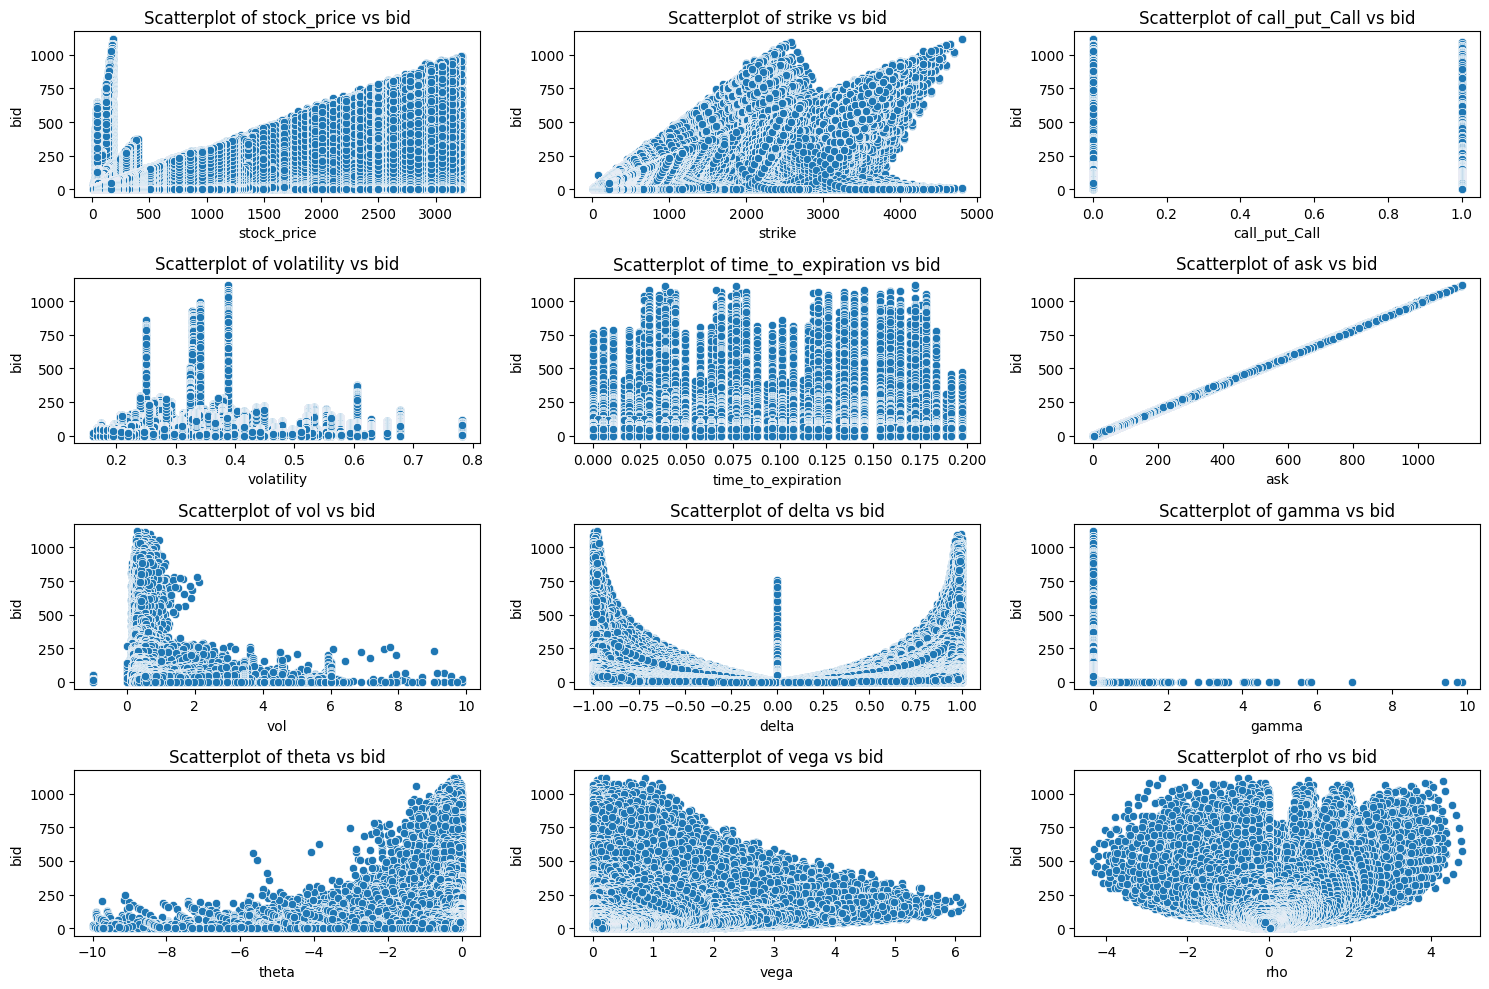

In [17]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# List of features to plot against the target variable
features = ['stock_price', 'strike', 'call_put_Call', 'volatility', 'time_to_expiration', 'ask', 'vol', 'delta', 'gamma', 'theta', 'vega', 'rho']
target = 'option_price'  # Output variable

# Loop through each feature to create scatterplots
for i, feature in enumerate(features):
    plt.subplot(4, 3, i + 1)  # Adjust the grid size as needed
    sns.scatterplot(x=df_train[feature], y=df_train[target])
    plt.title(f'Scatterplot of {feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)

plt.tight_layout()
plt.show()

In [33]:
# Features and target variable
features = ['stock_price', 'strike', 'call_put_Call', 'volatility', 'time_to_expiration', 'vol', 'delta', 'gamma', 'theta', 'vega', 'rho']  # Input features
target = 'option_price'  # Output variable

# Create feature and target arrays
X_train = df[features]
y_train = df[target]

# Standardize features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features, index=X_test.index)

del X_train, X_test

There is no linear relationship between any of the features and the target variable except for ask vs bid. Thus, a linear regression model is not suitable for this dataset.

'Ask' also has an extremely strong linear correlationship with 'Bid' and I anticipate it overshadowing all the other variables, so I removed that variable from the features

## Random Forest Regressor

In [39]:
n_repeats = 5
rmse_list = []  # List to store RMSE for each iteration

for _ in range(n_repeats):
    # Randomly select a subset of the indices
    sample_size = int(0.7 * len(X_train_scaled))  # Adjust the fraction as needed
    indices = np.random.choice(len(X_train_scaled), size=sample_size, replace=False)
    
    # Create a sampled version of your data
    X_train_sampled = X_train_scaled.iloc[indices]
    y_train_sampled = y_train.iloc[indices]
    
    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=25, n_jobs=-1, random_state=42)
    model.fit(X_train_sampled, y_train_sampled)
    
    # Make predictions and evaluate the model
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_list.append(rmse)

# Calculate the average RMSE across all repetitions
average_rmse = np.mean(rmse_list)
print(f'Average RMSE over {n_repeats} repetitions: {average_rmse}')

Average RMSE over 5 repetitions: 0.4757520934872098


## XGBoost

In [ ]:
### HYPERPARAMETERS TUNING ###

def train_and_evaluate_xgboost(X_train_scaled, y_train, X_test_scaled, y_test):
    # Define the parameter grid to search for the best reg_alpha value
    param_grid = {
        'n_estimators': [500, 1000, 2000],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [4, 5, 6],
        'subsample': [0.55, 0.6, 0.65],
        'colsample_bytree': [0.4, 0.45, 0.5],
        'reg_alpha': [0.01, 0.05, 0.1],
        'reg_lambda': [0.01, 0.05, 0.1]
    }

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(random_state=42)
    
    # Define the scorer as RMSE
    rmse_scorer = make_scorer(mean_squared_error, squared=False)
    
    # Set up GridSearchCV to find the best combination of hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=rmse_scorer, 
                               cv=3, verbose=2, n_jobs=-1)
    
    # Fit the model using GridSearchCV
    grid_search.fit(X_train_scaled, y_train)
    
    # Best model found by GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Make predictions on the training set with the best model
    y_train_pred = best_model.predict(X_train_scaled)
    
    # Make predictions on the test set with the best model
    y_test_pred = best_model.predict(X_test_scaled)
    
    # Evaluate the best model using RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Print the best hyperparameters and the evaluation metrics
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Training RMSE: {rmse_train}")
    print(f"Test RMSE: {rmse_test}")
    
    # Return the best model, training predictions, and test predictions
    return best_model, y_train_pred, y_test_pred

# Example usage
model, y_train_pred, y_test_pred = train_and_evaluate_xgboost(X_train_scaled, y_train, X_test_scaled, y_test)

In [17]:
### BEST MODEL ###

def train_and_evaluate_xgboost(X_train_scaled, y_train, X_test_scaled, y_test):
    # Initialize the XGBoost model
    model = xgb.XGBRegressor(n_estimators=2000,
                             learning_rate=0.15,
                             max_depth=6,
                             reg_alpha=0.01,
                             reg_lambda=0.1,
                             subsample = 0.55,
                             colsample_bytree = 0.4, 
                             random_state=42)
    
    # Train the model on the scaled training set
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the training set
    y_train_pred = model.predict(X_train_scaled)
    
    # Make predictions on the test set
    y_test_pred = model.predict(X_test_scaled)
    
    # Evaluate the model using Root Mean Squared Error (RMSE)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Print the evaluation metrics
    print(f"Training RMSE: {rmse_train}")
    print(f"Test RMSE: {rmse_test}")
    
    # Return the model, training predictions, and test predictions
    return model, y_train_pred, y_test_pred

# Example usage
model, y_train_pred, y_test_pred = train_and_evaluate_xgboost(X_train_scaled, y_train, X_test_scaled, y_test)

Training RMSE: 1.1953134824460796
Test RMSE: 0.856718909990082


## Experiment with Light Gradient Boosting (LGBM)

In [ ]:
### HYPERPARAMETERS TUNING ###

def train_and_evaluate_lightgbm_with_gridsearch(X_train, y_train, X_test, y_test):
    # Define the initial parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [250, 500, 1000],
        'learning_rate': [0.1, 0.15, 0.2],
        'max_depth': [4, 5, 6],
        'subsample': [0.55, 0.6, 0.65],
        'colsample_bytree': [0.4, 0.5, 0.6],
        'reg_alpha': [0.01, 0.05, 0.1],
        'reg_lambda': [0.01, 0.05, 0.1],
        'num_leaves': [31, 63],
        'random_state': [42]
    }

    # Initialize the LGBMRegressor model
    model = lgb.LGBMRegressor(objective='regression', boosting_type='gbdt')

    # Use RMSE as the scoring metric for GridSearchCV
    rmse_scorer = make_scorer(mean_squared_error, squared=False)

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=rmse_scorer,
        cv=1,  # 3-fold cross-validation
        verbose=2,
        n_jobs=-1  # Use all CPU cores for parallelism
    )
    
    # Fit the model with GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Extract the best model found by GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Make predictions on the training set with the best model
    y_train_pred = best_model.predict(X_train)
    
    # Make predictions on the test set with the best model
    y_test_pred = best_model.predict(X_test)
    
    # Evaluate the best model using RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Print the best hyperparameters and the evaluation metrics
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Training RMSE: {rmse_train}")
    print(f"Test RMSE: {rmse_test}")
    
    # Return the best model, training predictions, and test predictions
    return best_model, y_train_pred, y_test_pred

# Example usage
model, y_train_pred, y_test_pred = train_and_evaluate_lightgbm_with_gridsearch(X_train_scaled, y_train, X_test_scaled, y_test)


In [51]:
### BEST MODEL ###

def train_and_evaluate_lightgbm(X_train_scaled, y_train, X_test_scaled, y_test):
    # Initialize the XGBoost model
    model = lgb.LGBMRegressor(n_estimators=2000,
                             learning_rate=0.2,
                             max_depth=6,
                             reg_alpha=0.05,
                             reg_lambda=0.05,
                             subsample = 0.5,
                             colsample_bytree = 0.6,
                             num_leaves = 63,
                             random_state=42)
    
    # Train the model on the scaled training set
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the training set
    y_train_pred = model.predict(X_train_scaled)
    
    # Make predictions on the test set
    y_test_pred = model.predict(X_test_scaled)
    
    # Evaluate the model using Root Mean Squared Error (RMSE)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Print the evaluation metrics
    print(f"Training RMSE: {rmse_train}")
    print(f"Test RMSE: {rmse_test}")
    
    # Return the model, training predictions, and test predictions
    return model, y_train_pred, y_test_pred

# Example usage
model, y_train_pred, y_test_pred = train_and_evaluate_lightgbm(X_train_scaled, y_train, X_test_scaled, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2341
[LightGBM] [Info] Number of data points in the train set: 5927896, number of used features: 11
[LightGBM] [Info] Start training from score 12.492101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

## Final Result Performance (RMSE):

- BS: 3.34
- RandomForest: 0.61
- XGBoost: 0.86
- LGBM: 0.70